<a href="https://colab.research.google.com/github/ffvoigt/neuromatch-compneuro-2022-project/blob/development/Feature_Extraction_NM2022_Sfenj1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General

The job of this notebook is to:

* Load the preprocessed tracking data into a `master_df` DataFrame

* Add handcrafted features as columns to `master_df`

* Save the `master_df` so it can be used for later classification notebooks

## Style / naming guide / coding hints

* Axes in column labels such as 'X' and 'Y' are always capitalized: e.g. `left_ear_X`
* All coordinates are in cm, area in cm^2
* All angles are in degrees
* 0° is up / north in the video frame
* whenever extracting features, do sanity checks on them:
  * plot time course: are there weird discontinuities etc.?
* often, rounding values makes sense to reduce numerical errors (e.g. angles such as 34.999999° are biologically meaningless -> round to 35°

## ToDo 
* Check order of polygon points for the area calculation

# Housekeeping

In [102]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colors
from matplotlib import rc
import matplotlib.patches as mpatches
import seaborn as sns

# Loading the data from Google Drive

In [2]:
#Because we are using a Shared with me drive, we need to have a small workaround
#In your shared with me folder, right click on:
#NMA_2022_Sfenj_Group_1"
#And click "Make a shortcut", and have this shortcut within your own drive

#now we can mount our drive
from pickle import load
# mount google drive
from google.colab import drive
drive.mount('/content/drive')
#Since you have mounted your drive, which includes this shortcut, you can now access the files within that shortcut:
master_df = pd.read_csv('/content/drive/MyDrive/NMA_2022_Sfenj_Group_1/tracking_df.csv')

#test by showing the head
master_df.head()

Mounted at /content/drive


,Unnamed: 0,frame_num,session_num,mouse_id,annotations,nose_X,nose_Y,left_ear_X,left_ear_Y,neck_X,neck_Y,right_ear_X,right_ear_Y,left_hip_X,left_hip_Y,right_hip_X,right_hip_Y,tailbase_X,tailbase_Y
0,0,0,0,0,3,831.659204,202.914433,805.659204,250.914433,775.659204,189.914433,780.659204,225.914433,711.659204,278.914433,711.659204,192.914433,643.659204,220.914433
1,1,1,0,0,1,833.050439,201.895063,809.050439,251.895063,778.050439,193.895063,783.050439,229.895063,723.050439,287.895063,717.050439,192.895063,644.050439,227.895063
2,2,2,0,0,1,838.718976,179.862692,816.718976,244.862692,776.718976,193.862692,787.718976,225.862692,730.718976,286.862692,713.718976,196.862692,646.718976,233.862692
3,3,3,0,0,1,826.757507,175.148063,815.757507,235.148063,774.757507,187.148063,785.757507,218.148063,743.757507,282.148063,711.757507,198.148063,644.757507,237.148063
4,4,4,0,0,1,822.045709,174.457936,812.045709,222.457936,768.045709,178.457936,779.045709,211.457936,749.045709,278.457936,709.045709,194.457936,646.045709,233.457936


## Conversion to cm 
The tracking data is provided in "pixel" units, to convert into Centimeters units, all coordinates need to be divided by 37.7

In [3]:
## converts dataframe into units of cm
## uses conversion of 37.7 pixels/cm
pos_names = ['nose_X', 'left_ear_X', 'right_ear_X','neck_X', 'left_hip_X', 'right_hip_X', 'tailbase_X', 'nose_Y', 'left_ear_Y', 'right_ear_Y','neck_Y', 'left_hip_Y', 'right_hip_Y', 'tailbase_Y']
master_df[pos_names]= master_df[pos_names]/37.7

### Helper functions and plotting tools

In [87]:
# Function to grab a certain column/feature for a specific mouse id and session:
def grab_feature(featurename, session, mouse_id):
  return master_df.loc[(master_df['session_num']==session) & (master_df['mouse_id']==mouse_id)][featurename]

In [115]:
def plot_feature_vs_frame(feature_label, session_num=0, mouse_id=0):
    feature_series = grab_feature(feature_label, session_num, mouse_id)
    plt.figure(figsize=(10, 6))
    plt.plot(feature_series)

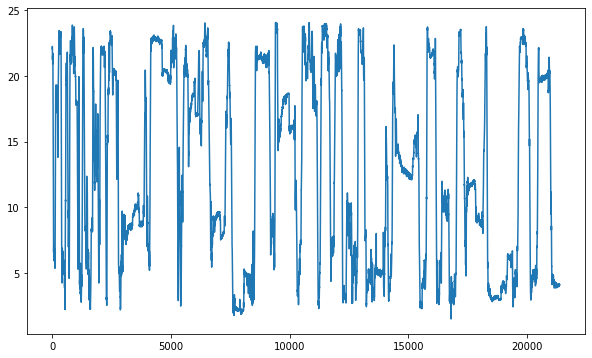

In [116]:
plot_feature_vs_frame('nose_X')

In [109]:
def plot_feature_vs_xy_heatmap(feature_label, session_num=0, mouse_id=0):
  subframe = master_df.loc[(master_df['session_num']==session_num) & (master_df['mouse_id']==mouse_id)]
  x_series = subframe['centroid_body_X']
  y_series = subframe['centroid_body_Y']
  feature_series = subframe[feature_label]

  plt.figure(figsize=(10, 6))
  heatmap = sns.scatterplot(x=x_series, y=y_series, hue=feature_series, palette="magma");
  heatmap.legend(bbox_to_anchor=(1.22, 1), loc='upper right');

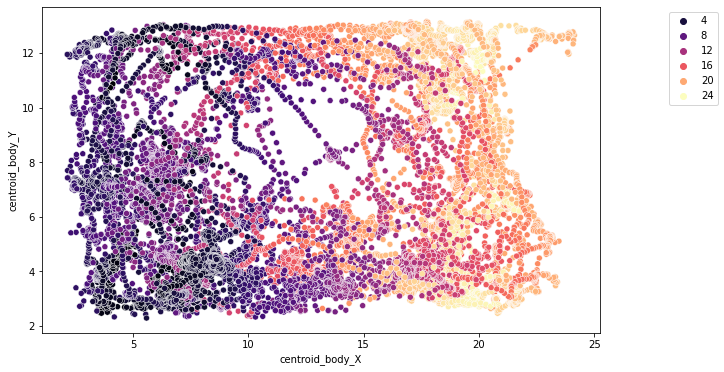

In [110]:
plot_feature_vs_xy_heatmap('nose_X')

# Adding features

#### Postion centroids

Centroids are calculated by taking the mean of the individual coordinates.

In [4]:
#Now we can calculate features in the master_df
#re-create indexing variables from when master_df was initially created
master_dict = {'frame_num':[], 'session_num': [], 'mouse_id': [], 'annotations':[]}
pos_x_names = ['nose_X', 'left_ear_X', 'right_ear_X','neck_X', 'left_hip_X', 'right_hip_X', 'tailbase_X'] 
pos_y_names = ['nose_Y', 'left_ear_Y', 'right_ear_Y','neck_Y', 'left_hip_Y', 'right_hip_Y', 'tailbase_Y']

# get average of all XY positions for centroid location
#calcuate the mean of all x's and y's (centroid of all 7 pts)
master_df['centroid_X'] = master_df[pos_x_names].mean(axis=1) 
master_df['centroid_Y'] = master_df[pos_y_names].mean(axis=1)

master_df['centroid_head_X'] = master_df[['nose_X', 'left_ear_X', 'right_ear_X','neck_X']].mean(axis=1)
master_df['centroid_head_Y'] = master_df[['nose_Y', 'left_ear_Y', 'right_ear_Y','neck_Y']].mean(axis=1)
master_df['centroid_body_X'] = master_df[['left_hip_X', 'right_hip_X', 'tailbase_X']].mean(axis=1)
master_df['centroid_body_Y'] = master_df[['left_hip_Y', 'right_hip_Y', 'tailbase_Y']].mean(axis=1)

master_df.head()

,Unnamed: 0,frame_num,session_num,mouse_id,annotations,nose_X,nose_Y,left_ear_X,left_ear_Y,neck_X,...,right_hip_X,right_hip_Y,tailbase_X,tailbase_Y,centroid_X,centroid_Y,centroid_head_X,centroid_head_Y,centroid_body_X,centroid_body_Y
0,0,0,0,0,3,22.059926,5.382346,21.370271,6.655555,20.574515,...,18.876902,5.117094,17.073188,5.859799,19.934121,5.920428,21.177963,5.766961,18.275664,6.125051
1,1,1,0,0,1,22.096829,5.355307,21.460224,6.681567,20.637943,...,19.019906,5.116580,17.083566,6.044962,20.035442,6.010858,21.241391,5.819498,18.427509,6.266005
2,2,2,0,0,1,22.247188,4.770894,21.663633,6.495032,20.602625,...,18.931538,5.221822,17.154349,6.203254,20.125172,5.919056,21.351962,5.599806,18.489451,6.344722
3,3,3,0,0,1,21.929907,4.645837,21.638130,6.237349,20.550597,...,18.879509,5.255917,17.102321,6.290400,20.095879,5.809157,21.240252,5.408437,18.570049,6.343450
4,4,4,0,0,1,21.804926,4.627531,21.539674,5.900741,20.372565,...,18.807578,5.158035,17.136491,6.192518,20.027738,5.658225,21.095377,5.217717,18.604219,6.245569


#### Head vs. body orientation

In [5]:
# head angle calculation
vec_tail2neck_x = master_df['neck_X'] - master_df['tailbase_X']
vec_tail2neck_y = master_df['neck_Y'] - master_df['tailbase_Y']
vec_neck2nose_x = master_df['nose_X'] - master_df['neck_X']
vec_neck2nose_y = master_df['nose_Y'] - master_df['neck_Y']

v_ = vec_tail2neck_x * vec_neck2nose_y - vec_tail2neck_y * vec_neck2nose_x
w_ = vec_tail2neck_x * vec_neck2nose_x + vec_tail2neck_y * vec_neck2nose_y

master_df['head_vs_body_angle'] = np.degrees(np.arctan2(v_,w_))

#### Head vs. cage orientation

In [6]:
vec_neck2nose_x = master_df['nose_X'] - master_df['neck_X']
vec_neck2nose_y = master_df['nose_Y'] - master_df['neck_Y']
# basis vector pointing north
vec_x = 0
vec_y = 1

v_ = vec_x * vec_neck2nose_y - vec_y * vec_neck2nose_x
w_ = vec_x * vec_neck2nose_x + vec_y * vec_neck2nose_y

master_df['head_orientation'] = np.degrees(np.arctan2(v_,w_))

#### Speed and accelleration

Speed is defined as distance of adjacent frames of the centroids. Accelaration is the difference cross frames of the speed. speed and data are converted to cm/s and cm/s**2 using 30Hz as frame rate.

As we would like to maybe add smoothing filter to the speed data and the start and end of each session and each animal would be problematic for the filter operation on the whole master_df dict, here we use two for loops to work on individual animal and session to get speed. Currently, no smoothing filter is used yet.



In [7]:
# #### IMPROVEMENT ########
# use np.diff pre-pad function: 
# and use np.linarg.norm function 
# #################

# ############ Functions #######################
# define a helper function to calculate speed and normalize to frame rate
def speed_calc(x,y,framerate):
  speed = np.sqrt(x**2+y**2)*framerate
  return speed

# function to take in master_df, calculate 3 speed and 3 acceleration return to 3 variable
def get_features_speed_acc(master_df, framerate):
  # allocate empty varibles
  rec_spd_centr_head = []
  rec_spd_centr_hip = []
  rec_spd_centr_all = []
  rec_acc_centr_head = [] # cm/s^2
  rec_acc_centr_hip = []
  rec_acc_centr_all = []

  for ses in master_df['session_num'].unique():
    session =  master_df[master_df['session_num'] == ses]
    for ani in session['mouse_id'].unique():
      animal = session[session['mouse_id'] == ani]
      # head centroid
      x_diff = np.diff( animal['centroid_head_X'] )
      y_diff = np.diff( animal['centroid_head_Y'] )    
      tmp_X = np.hstack((np.nan,  x_diff) ).T
      tmp_Y = np.hstack((np.nan,  y_diff) ).T    
      tmp_spd = speed_calc(tmp_X,tmp_Y,framerate) # speed within a session an animal  
      rec_spd_centr_head = np.append(rec_spd_centr_head, tmp_spd)
      # accelaration: diff(speed)
      tmp_acc = ( np.hstack((np.nan, np.diff(tmp_spd))).T)/(1/framerate) # cm/s^2
      rec_acc_centr_head = np.append(rec_acc_centr_head, tmp_acc)

      # hip centroid
      x_diff = np.diff( animal['centroid_body_X'] )
      y_diff = np.diff( animal['centroid_body_Y'] )
      tmp_X = np.hstack((np.nan,  x_diff) ).T
      tmp_Y = np.hstack((np.nan,  y_diff) ).T    
      tmp_spd = speed_calc(tmp_X,tmp_Y,framerate)  
      rec_spd_centr_hip = np.append(rec_spd_centr_hip, tmp_spd)
      tmp_acc = (np.hstack((np.nan, np.diff(tmp_spd))).T)/(1/framerate)
      rec_acc_centr_hip = np.append(rec_acc_centr_hip, tmp_acc)

      # all parts centroid
      x_diff = np.diff( animal['centroid_X'] )
      y_diff = np.diff( animal['centroid_Y'] )
      tmp_X = np.hstack((np.nan,  x_diff) ).T
      tmp_Y = np.hstack((np.nan,  y_diff) ).T    
      tmp_spd = speed_calc(tmp_X,tmp_Y,framerate)  
      rec_spd_centr_all = np.append(rec_spd_centr_all, tmp_spd)
      tmp_acc = (np.hstack((np.nan, np.diff(tmp_spd))).T)/(1/framerate)
      rec_acc_centr_all = np.append(rec_acc_centr_all, tmp_acc)
  return   rec_spd_centr_head, rec_spd_centr_hip, rec_spd_centr_all, rec_acc_centr_head, rec_acc_centr_hip, rec_acc_centr_all

# ###############################################
# define frame rate 30Hz
frame_rate = 30 

# run the function
rec_spd_centr_head, rec_spd_centr_hip, rec_spd_centr_all, rec_acc_centr_head, rec_acc_centr_hip, rec_acc_centr_all = get_features_speed_acc(master_df, frame_rate)

# add speed and acceleration to master_df. 
# depending on what we want to do, we can append them after calculating all features. currently commented out
# # append centroid speeds (3 variables) to the master_df
master_df['spd_head_centroid'] = rec_spd_centr_head
master_df['spd_body_centroid'] = rec_spd_centr_hip
master_df['spd_centroid'] = rec_spd_centr_all

# # append centroid speeds (3 variables) to the master_df
master_df['acc_head_centroid'] = rec_acc_centr_head
master_df['acc_body_centroid'] = rec_acc_centr_hip
master_df['acc_centroid'] =      rec_acc_centr_all

In [8]:
master_df.head()

,Unnamed: 0,frame_num,session_num,mouse_id,annotations,nose_X,nose_Y,left_ear_X,left_ear_Y,neck_X,...,centroid_body_X,centroid_body_Y,head_vs_body_angle,head_orientation,spd_head_centroid,spd_body_centroid,spd_centroid,acc_head_centroid,acc_body_centroid,acc_centroid
0,0,0,0,0,3,22.059926,5.382346,21.370271,6.655555,20.574515,...,18.275664,6.125051,26.285642,-76.930682,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,0,0,1,22.096829,5.355307,21.460224,6.681567,20.637943,...,18.427509,6.266005,22.513173,-81.724107,2.470806,6.215506,4.074207,NaN,NaN,NaN
2,2,2,0,0,1,22.247188,4.770894,21.663633,6.495032,20.602625,...,18.489451,6.344722,4.378373,-102.724356,7.378437,3.004966,3.851131,147.228931,-96.316187,-6.692275
3,3,3,0,0,1,21.929907,4.645837,21.638130,6.237349,20.550597,...,18.570049,6.343450,8.042894,-102.994617,6.647651,2.418231,3.412081,-21.923601,-17.602061,-13.171507
4,4,4,0,0,1,21.804926,4.627531,21.539674,5.900741,20.372565,...,18.604219,6.245569,20.030394,-94.236395,7.185160,3.110226,4.968029,16.125266,20.759847,46.678465


#### Distance between animals

In [82]:
# Function to grab a certain column/feature for a specific mouse id and session:
def grab_feature(featurename, session, mouse_id):
  return master_df.loc[(master_df['session_num']==session) & (master_df['mouse_id']==mouse_id)][featurename]

In [84]:
# Adds a column filled with zeros to the DataFrame
master_df['distance'] = 0
num_sessions = master_df['session_num'].max()

for session in range(0, num_sessions):
  mouse0_x_centroid = grab_feature('centroid_body_X', session=session, mouse_id=0)
  mouse0_y_centroid = grab_feature('centroid_body_Y', session=session, mouse_id=0)
  mouse1_x_centroid = grab_feature('centroid_body_X', session=session, mouse_id=1)
  mouse1_y_centroid = grab_feature('centroid_body_Y', session=session, mouse_id=1)

  # Get the indices where the mouse 0 and 1 start and end
  mouse0_start_index = mouse0_x_centroid.index[0]
  mouse0_end_index = mouse0_x_centroid.index[-1]
  
  mouse1_start_index = mouse1_x_centroid.index[0]
  mouse1_end_index = mouse1_x_centroid.index[-1]

  # Currently, the dataframes are indexed by frame, we need to drop the indices for further calculation: 
  mouse0_x_centroid.reset_index(drop=True, inplace=True)
  mouse0_y_centroid.reset_index(drop=True, inplace=True)
  mouse1_x_centroid.reset_index(drop=True, inplace=True)
  mouse1_y_centroid.reset_index(drop=True, inplace=True)

  # Get the vector pointing from Mouse 0 to 1 and calculate its length
  delta_x = mouse1_x_centroid - mouse0_x_centroid
  delta_y = mouse1_y_centroid - mouse0_y_centroid

  distance = np.sqrt(delta_x**2 + delta_y**2)

  # Replace the corresponding values in the master_df for both Mouse 0 and Mouse 1
  # As distance contains an index, .to_numpy() avoids overwriting the first session distances 
  # again and again and filling the rest of the DataFrame with NaNs
  master_df.loc[mouse0_start_index:mouse0_end_index,'distance'] = distance.to_numpy()
  master_df.loc[mouse1_start_index:mouse1_end_index,'distance'] = distance.to_numpy()

#### Head area

In [97]:
## calculation to get area of head, can use the same to get area of body, order of points matters when creating the polygon, order below needs to be fixed!!
from shapely.geometry import Polygon
poly_area_head =[]
for x in range(0,len(master_df['frame_num'])):
  poly = Polygon([(master_df.nose_X.iloc[x], master_df.nose_Y.iloc[x]), (master_df.left_ear_X.iloc[x], master_df.left_ear_Y.iloc[x]), (master_df.neck_X.iloc[x], master_df.neck_Y.iloc[x]),(master_df.right_ear_X.iloc[x], master_df.right_ear_Y.iloc[x])])
  poly_area_head.append(poly.area)
master_df["poly_area_head"] = poly_area_head

#### Body area

In [95]:
## calculation to get area of head, can use the same to get area of body, order of points matters when creating the polygon, order below needs to be fixed!!
from shapely.geometry import Polygon
poly_area_body =[]
for x in range(0,len(master_df['frame_num'])):
  poly = Polygon([(master_df.neck_X.iloc[x], master_df.neck_Y.iloc[x]), (master_df.left_hip_X.iloc[x], master_df.left_hip_Y.iloc[x]), (master_df.right_hip_X.iloc[x], master_df.right_hip_Y.iloc[x]),(master_df.tailbase_X.iloc[x], master_df.tailbase_Y.iloc[x])])
  poly_area_body.append(poly.area)
master_df["poly_area_body"] = poly_area_body

## Sanity checking: Plots and heatmaps

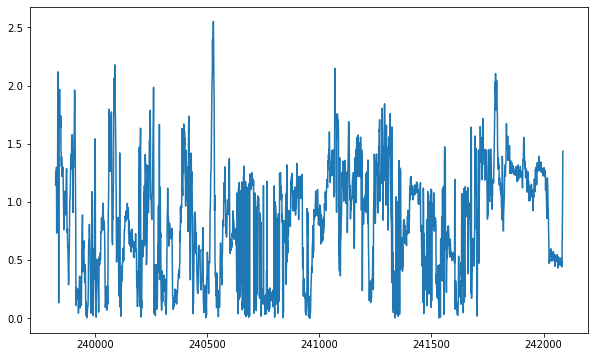

In [118]:
plot_feature_vs_frame('poly_area_body', session_num=12, mouse_id=0)

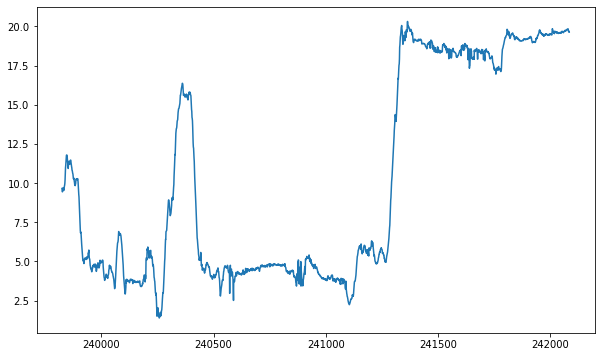

In [119]:
plot_feature_vs_frame('distance', session_num=12, mouse_id=0)

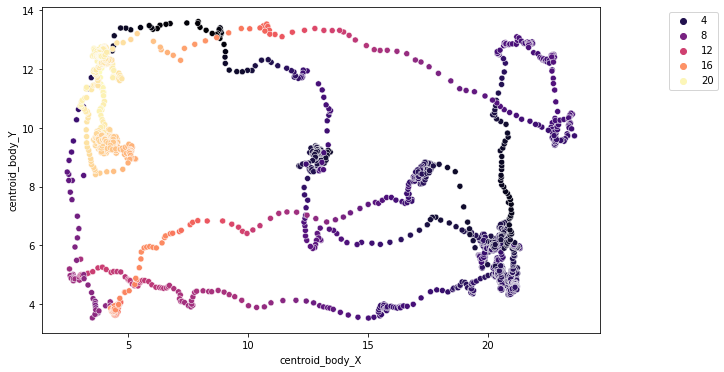

In [120]:
plot_feature_vs_xy_heatmap('distance', session_num=12, mouse_id=0)

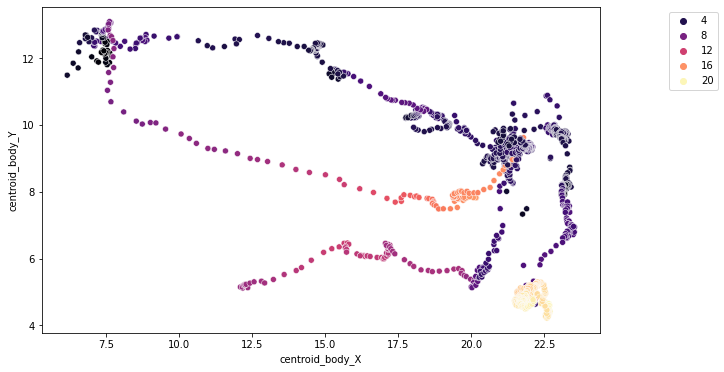

In [121]:
plot_feature_vs_xy_heatmap('distance', session_num=12, mouse_id=1)

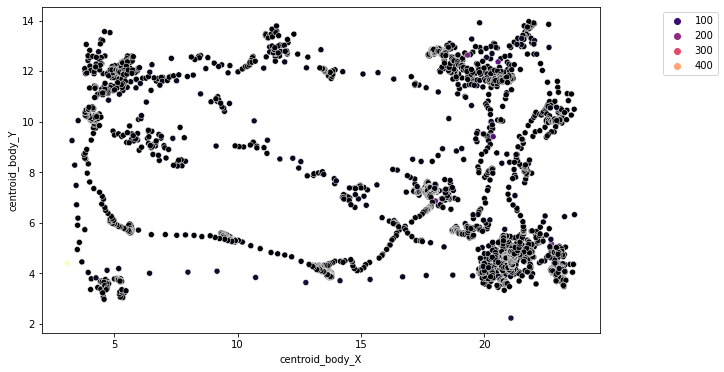

In [127]:
plot_feature_vs_xy_heatmap('spd_centroid', session_num=5, mouse_id=1)

## Saving new feature frame to .csv

For now, the exported dataframe is unstable as the features are not yet fully checked.

In [129]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [128]:
master_df.to_csv('unstable_feature_df.csv')